# CPS 840 / CP 8318 Assignment 2
# Assignment 2 - [Shaun Mathew] - [500572818]
## CPS 840 [30 Marks]
## CP 8318 [36 Marks]


## Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# You may need some sklearn specific imports, or other standard toolboxes

## Load dataset

In [5]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

## Split data

In [6]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [7]:
def get_emotion(whichemotion):
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

(28709, 48, 48)
(28709, 7)
(3589, 48, 48)
(3589, 7)


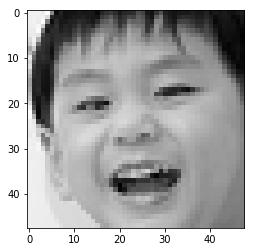

facial emotion: happy


In [8]:
print(x_training.shape)
print(y_training.shape)

print(x_testing.shape)
print(y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training[sampleindex, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))



# Part I : Happy or Sad

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [9]:
# YOUR CODE HERE

rand_state = np.random.RandomState(seed=0)

#getting happy and sad examples
happy_indices = np.nonzero(y_training[:,3])
sad_indices = np.nonzero(y_training[:,4])

happy_indices_t = np.nonzero(y_testing[:,3])
sad_indices_t = np.nonzero(y_testing[:,4])

#Happy is 1, sad is 0
transform = np.expand_dims(np.array([0,0,0,1,0,0,0]),axis=0).T

#concatenating
hs_train_X = np.concatenate((x_training[happy_indices], x_training[sad_indices]))
hs_train_Y = np.concatenate((y_training[happy_indices], y_training[sad_indices]))
hs_train_Y = hs_train_Y.dot(transform)

#shuffling labels and training
perm = np.random.permutation(len(hs_train_Y))

hs_train_X = hs_train_X[perm]
hs_train_Y = hs_train_Y[perm]

#Same for test set
hs_test_X = np.concatenate((x_testing[happy_indices_t], x_testing[sad_indices_t]))
hs_test_Y = np.concatenate((y_testing[happy_indices_t], y_testing[sad_indices_t]))
hs_test_Y = hs_test_Y.dot(transform)



[4 Marks] b. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. You may consider using one or both of these in the steps that follow if they are of any value (this is for you to decide).

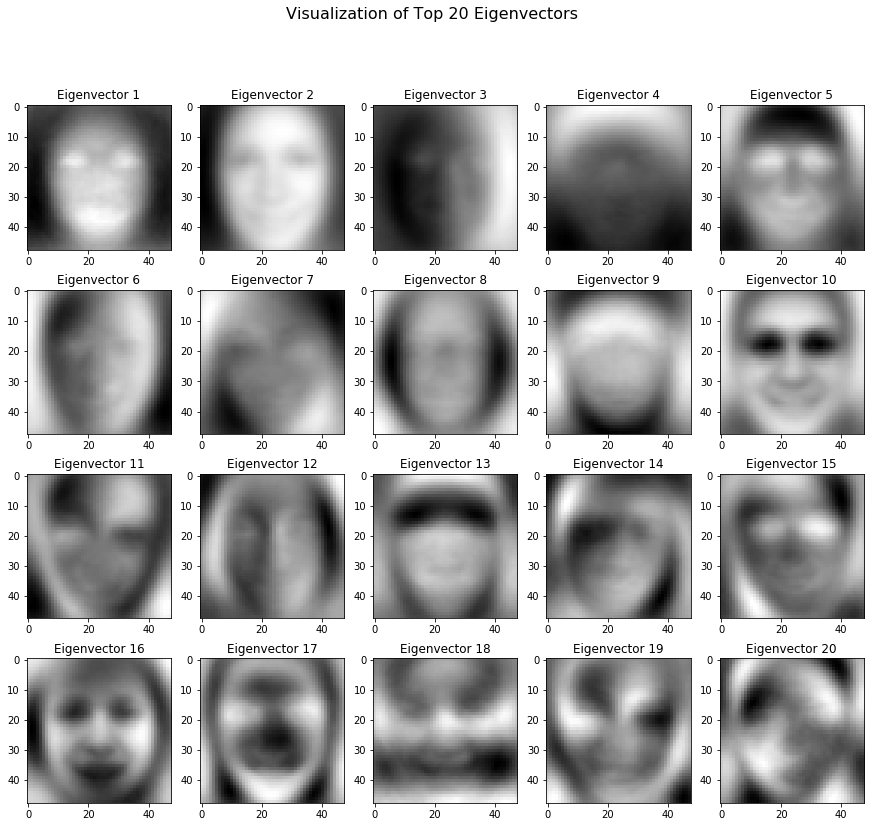

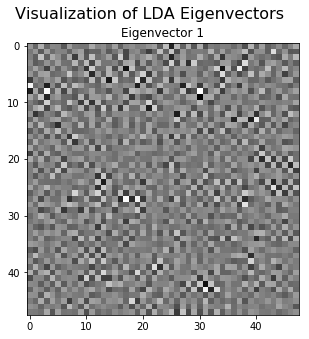

In [75]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

rand_state = np.random.RandomState(seed=0)

num_samples = 150

#Chooaing random sample to visualize
sample_indices = rand_state.permutation(len(hs_train_Y.flatten()))[:num_samples]

#20 pca components
pca = PCA(n_components=20)
res = pca.fit_transform(hs_train_X.reshape(-1,48*48))

eigen_vectors = pca.components_

fig=plt.figure(figsize=(15, 13))
fig.suptitle('Visualization of Top 20 Eigenvectors', fontsize=16)
for i in range(1, 5*4 +1):
    fig.add_subplot(4, 5, i)
    plt.title("Eigenvector {}".format(i))
    plt.imshow(eigen_vectors[i-1].reshape(48,48), cmap="gray")
    plt.grid(False)
    
plt.show()

#Visualizing LDA (single dimension because dim is reduced to # of classes -1)
lda = LinearDiscriminantAnalysis()
res_lda = lda.fit_transform(hs_train_X.reshape(-1,48*48), hs_train_Y.flatten())
eigen_vectors_lda = lda.scalings_
fig=plt.figure(figsize=(15, 5))
fig.suptitle('Visualization of LDA Eigenvectors', fontsize=16)

for i in range(1,eigen_vectors_lda.shape[1] + 1):
    fig.add_subplot(1, eigen_vectors_lda.shape[1], i)
    plt.title("Eigenvector {}".format(i))
    plt.imshow(eigen_vectors_lda[:,i-1].reshape(48,48), cmap="gray")
    plt.grid(False)

plt.show()

[2 Marks] c. Apply naive Bayes to classify faces as happy or sad. Report your accuracy.

In [13]:
from sklearn.naive_bayes import GaussianNB

#Using Gaussian Naive Bayes
clf = GaussianNB()

clf.fit(res_lda[:,0].reshape(-1,1), hs_train_Y.flatten())

train_preds = clf.predict(res_lda[:,0].reshape(-1,1))
train_labels = hs_train_Y.flatten()

#transforming test set using learned transform from training
transformed_test = lda.transform(hs_test_X.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = hs_test_Y.flatten()

accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))



Accuracy on training: 79.1697799916978%
Accuracy on test: 67.50645994832041%


[2 Marks] d. Apply Logistic regression to classify faces as happy or sad. Report the accuracy.

In [12]:
from sklearn.linear_model import LogisticRegression

#Using logistic regression
clf = LogisticRegression()

clf.fit(res_lda[:,0].reshape(-1,1), hs_train_Y.flatten())

train_preds = clf.predict(res_lda[:,0].reshape(-1,1))
train_labels = hs_train_Y.flatten()

transformed_test = lda.transform(hs_test_X.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = hs_test_Y.flatten()

accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))


Accuracy on training: 79.1282689912827%
Accuracy on test: 67.31266149870801%


[2 Marks] e. Apply a Support Vector Machine to classify the faces as happy or sad. Choose parameters / arguments to try to maximize your accuracy. Report the accuracy.

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#No need to cross validate if already done once before.. save computation time
already_cv = True

#Performing cross validation with RBF and poly kernels, various C and gamma
if not already_cv:
    clf = GridSearchCV(SVC(), cv=3,
                       param_grid={"C": [1, 0.1, 0.01],
                                   "gamma": list(np.logspace(-2, 2, 3)),
                                  "kernel": ["rbf","poly"]
                                  })

else:
    clf = SVC(C=0.1, gamma=0.01,kernel="rbf")

clf.fit(res_lda[:,0].reshape(-1,1), hs_train_Y.flatten())

if not already_cv:
    print("Best params found through cross-validation: ", clf.best_params_)

train_preds = clf.predict(res_lda[:,0].reshape(-1,1))
train_labels = hs_train_Y.flatten()

transformed_test = lda.transform(hs_test_X.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = hs_test_Y.flatten()

accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))


Accuracy on training: 79.18638439186384%
Accuracy on test: 67.18346253229974%


[1 Mark] f. Which of the approaches above allow you to reliably determine the degree of happiness or sadness (i.e. how happy or how sad)? Which do you trust the most?

I would use logistic regression since it outputs probability of a class being positive, so probability of being happy vs. being sad. 

I would trust a SVM model the most out of the three, since it is possible the data is not linearly separable (even after lda) and may require the use of kernels. Logistic regression might not perform as well for this reason; furthermore, logistic regression is more sensitive to outliers when compared to svms. In the case Naive Bayes, I think that the independence assumption might be too strong of an assumption since images are highly correlated - this is assuming the training samples are image vectors.

[2 Marks] g. Based on your answer to f. show the 5 happiest faces and the 5 saddest faces.

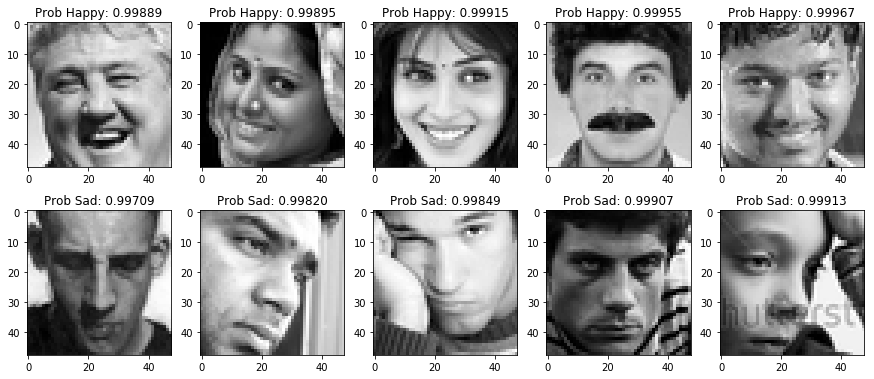

In [11]:
import matplotlib.pyplot as plt
import matplotlib

#Using logistic regression
clf = LogisticRegression()

clf.fit(res_lda[:,0].reshape(-1,1), hs_train_Y.flatten())

#predicting probabilities
train_preds = clf.predict_proba(res_lda[:,0].reshape(-1,1))
train_labels = hs_train_Y.flatten()

transformed_test = lda.transform(hs_test_X.reshape(-1,48*48))

test_preds = clf.predict_proba(transformed_test)
test_labels = hs_test_Y.flatten()

#Getting top 5 happiest/saddest faces in descending order
happiest_indices = np.argsort(train_preds[:,1])[:-6:-1][::-1]
saddest_indices = np.argsort(train_preds[:,0])[:-6:-1][::-1]

columns = 5
rows = 2

fig=plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=-0.7)

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    
    if i > 5:
        plt.title("Prob Sad: {:.5f}".format(train_preds[saddest_indices[(i-1)%5]][0]))
        plt.imshow(hs_train_X[saddest_indices[(i-1)%5]], cmap="gray")
        plt.grid(False)
    else:
        plt.title("Prob Happy: {:.5f}".format(train_preds[happiest_indices[i-1]][1]))
        plt.imshow(hs_train_X[happiest_indices[i-1]], cmap="gray") 
        plt.grid(False)

plt.show()

# Part II : Multi-class

## For this part you will repeat the tasks in Part I, but instead consider the multi-class problem and classify inputs according to all 7 classes. 

[4 Marks] a. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces used in part 1.

In [12]:
rand_state = np.random.RandomState(seed=0)

#Shuffling
perm = rand_state.permutation(len(y_training))
x_training = x_training[perm]
y_training = y_training[perm]


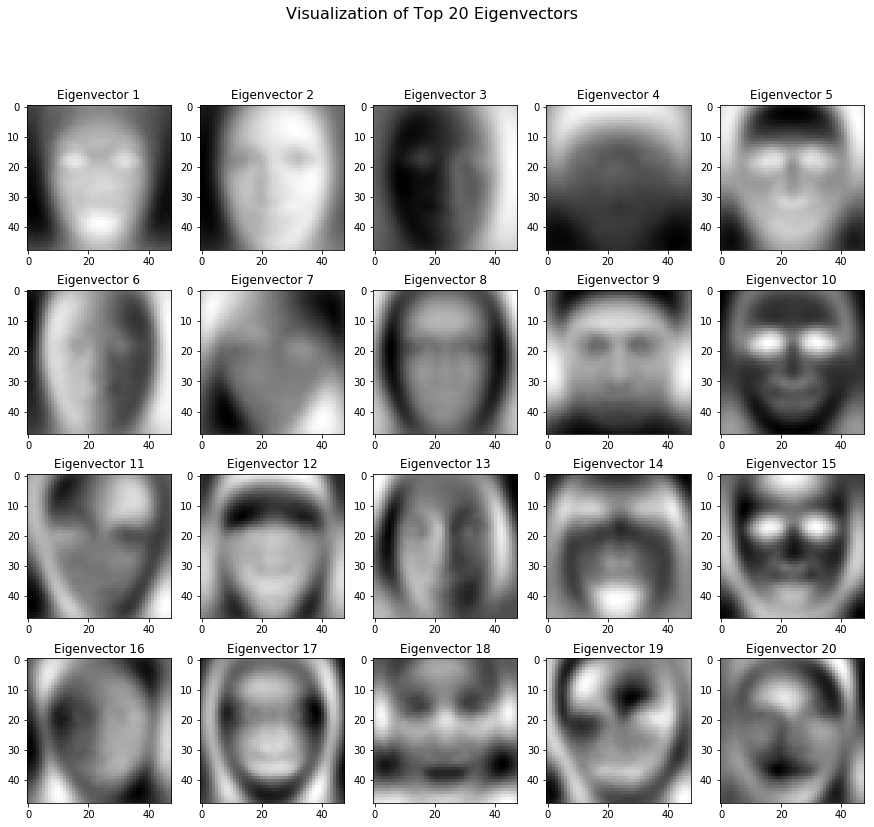

/Users/shaunmathew/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


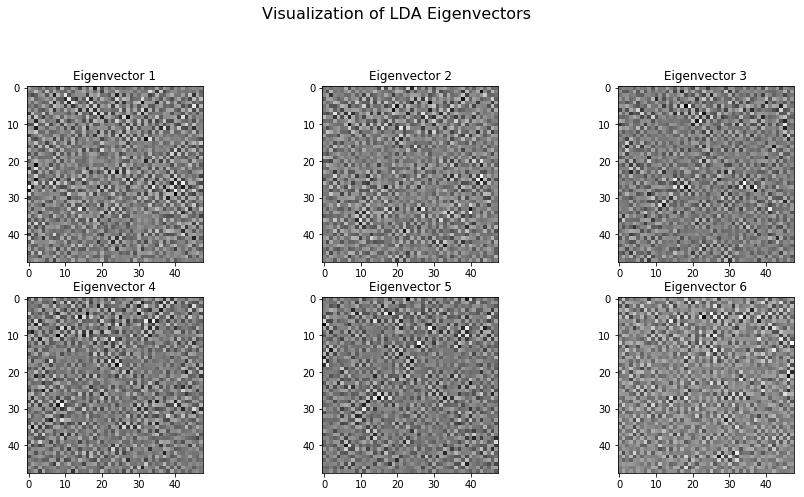

In [79]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#20 pca components
pca = PCA(n_components=20)
res = pca.fit_transform(x_training.reshape(-1,48*48))

eigen_vectors = pca.components_

fig=plt.figure(figsize=(15, 13))
fig.suptitle('Visualization of Top 20 Eigenvectors', fontsize=16)
for i in range(1, 5*4 +1):
    fig.add_subplot(4, 5, i)
    plt.title("Eigenvector {}".format(i))
    plt.imshow(eigen_vectors[i-1].reshape(48,48), cmap="gray")
    plt.grid(False)
    
plt.show()

#Visualizing LDA
lda = LinearDiscriminantAnalysis()
res_lda = lda.fit_transform(x_training.reshape(-1,48*48), np.argmax(y_training,axis=1).flatten())
eigen_vectors_lda = lda.scalings_
fig=plt.figure(figsize=(15, 11))
fig.suptitle('Visualization of LDA Eigenvectors', fontsize=16)

for i in range(1,eigen_vectors_lda.shape[1] + 1):
    fig.add_subplot(3, 3, i)
    plt.title("Eigenvector {}".format(i))
    plt.imshow(eigen_vectors_lda[:,i-1].reshape(48,48), cmap="gray")
    plt.grid(False)

plt.show()

[0.28923892 0.09806088 0.09456227 0.05485086 0.03047608 0.02577604
 0.02175146 0.01967509 0.01784103 0.01511698 0.01175348 0.01063666
 0.01021304 0.0100087  0.00924048 0.0081822  0.00789261 0.00659279
 0.00549384 0.0053649 ]
[0.28554511 0.09975522 0.09562513 0.05259499 0.03020039 0.02603815
 0.02470103 0.01933946 0.01750629 0.01538114 0.01273775 0.01083584
 0.01034789 0.00892174 0.0087166  0.00844153 0.00748934 0.00668395
 0.00591895 0.00572877]


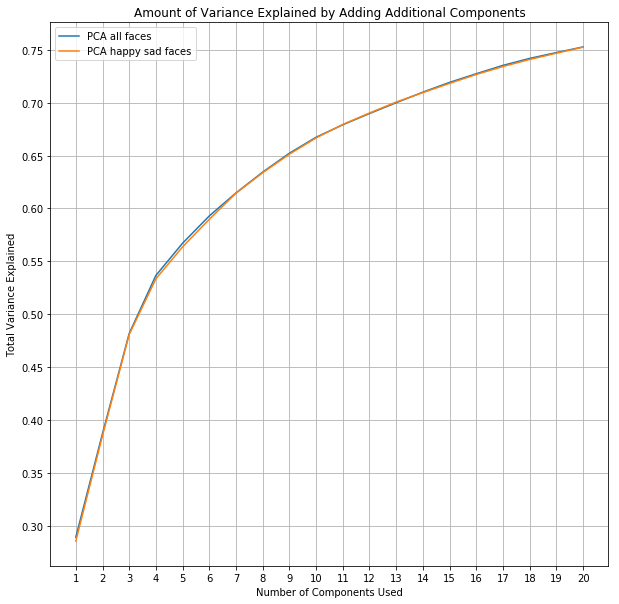

In [14]:
#Plotting cummulative variance for first 20 components
pca_hs = PCA(n_components=20)
res_hs = pca_hs.fit_transform(hs_train_X.reshape(-1,48*48))

pca_evr = np.cumsum(pca.explained_variance_ratio_)
pca_hs_evr = np.cumsum(pca_hs.explained_variance_ratio_)

print(pca.explained_variance_ratio_)
print(pca_hs.explained_variance_ratio_)

plt.figure(figsize=(10,10))
plt.plot(np.arange(1,21),pca_evr,label="PCA all faces")
plt.plot(np.arange(1,21),pca_hs_evr,label="PCA happy sad faces")
plt.yticks(np.arange(0.3, 0.8 , 0.05))
plt.xticks(np.arange(1,21), np.arange(1,21))
plt.xlabel("Number of Components Used")
plt.ylabel("Total Variance Explained")
plt.title("Amount of Variance Explained by Adding Additional Components")
plt.grid()
plt.legend()
plt.show()

[2 Marks] b. Classify the faces using Naive Bayes and report your accuracy.

In [93]:
#Naive Bayes - identical to binary case
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

train_labels = np.argmax(y_training,axis=1)

clf.fit(res_lda, train_labels)

train_preds = clf.predict(res_lda)

transformed_test = lda.transform(x_testing.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = np.argmax(y_testing,axis=1)

accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))



Accuracy on training: 49.43745863666446%
Accuracy on test: 35.16299804959599%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.

In Naive Bayes Multiclass classification, we simply choose the y (the class) that maximizes the posterior probability shown below. Here the xs are inputs and y is the class.

$\widehat{y} = \mathop{\mathrm{argmax}}_{y}P(y)\prod^{n}_{i=1}P(x_{i}\lvert y)$

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cnf_matrix, classes, normalize=False):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    
    if normalize:
        cnf_matrix = cnf_matrix/np.sum(cnf_matrix, axis=1)[:, np.newaxis]
        
    sns.heatmap(cnf_matrix, annot=True, ax=ax, fmt='g')
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(reversed(classes));
    
    plt.show()


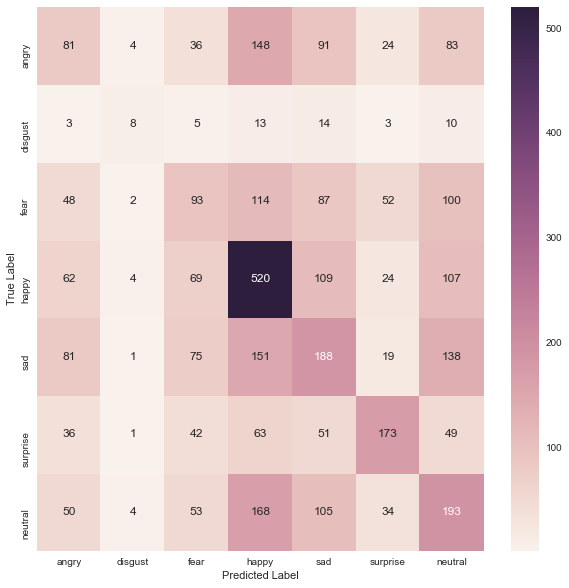

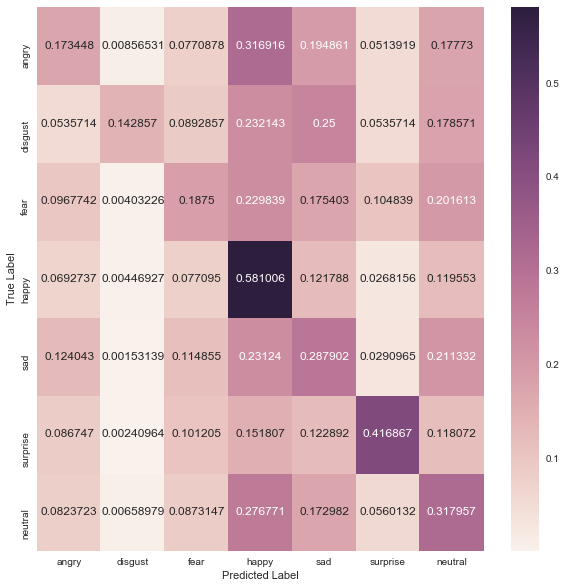

In [109]:
#Plotting confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, test_preds)
classes = [get_emotion(np.array([i])) for i in range(7)]

plot_confusion_matrix(cnf_matrix, classes)
plot_confusion_matrix(cnf_matrix, classes, normalize=True)


[2 Marks] c. Classify the faces using logistic regression and report your accuracy.

In [96]:
#Logistic Regression - identical to binary case
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

train_labels = np.argmax(y_training,axis=1)

clf.fit(res_lda, train_labels)

train_preds = clf.predict(res_lda)

transformed_test = lda.transform(x_testing.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = np.argmax(y_testing,axis=1)
accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))



Accuracy on training: 49.37476052805741%
Accuracy on test: 34.41069935915297%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.

In multiclass logistic regression, sklearn uses a one vs. all approach. So in our case, we would have n classifiers of the following form: angry vs not angry, disgust vs not disgust, fear vs. not fear etc... We then choose the class which corresponds to the highest output of the n classifiers. For example, if angry vs not angry produced the highest output, we would say the input most likely corresponds to the angry class.

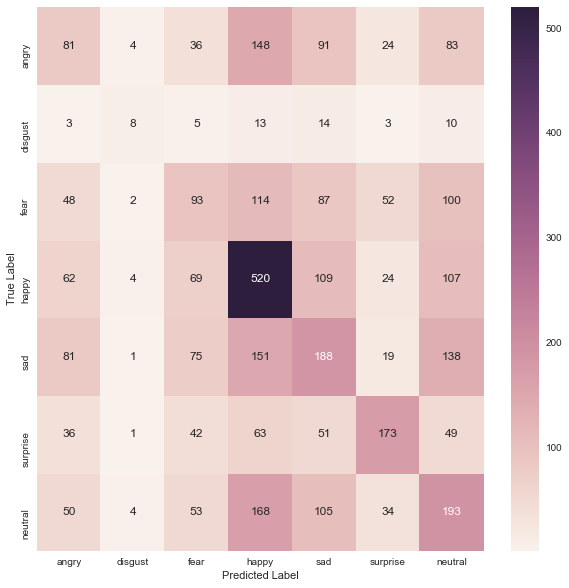

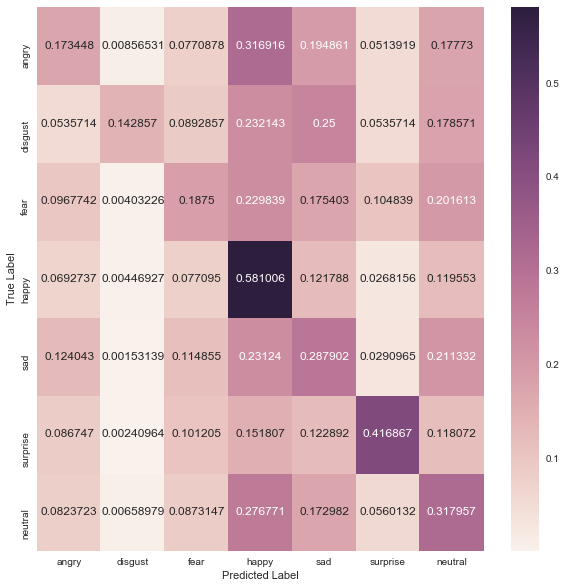

In [110]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, test_preds)
classes = [get_emotion(np.array([i])) for i in range(7)]

plot_confusion_matrix(cnf_matrix, classes)
plot_confusion_matrix(cnf_matrix, classes, normalize=True)


[2 Marks] d. Classify the faces using a support vector machine and report your accuracy.

In [98]:
#SVM - identical to binary case
from sklearn.svm import SVC

clf = SVC()

train_labels = np.argmax(y_training,axis=1)

clf.fit(res_lda, train_labels)

train_preds = clf.predict(res_lda)

transformed_test = lda.transform(x_testing.reshape(-1,48*48))

test_preds = clf.predict(transformed_test)
test_labels = np.argmax(y_testing,axis=1)
accuracy_train = np.sum(train_preds==train_labels)/len(train_labels)*100
accuracy_test = np.sum(test_preds==test_labels)/len(test_labels)*100

print("Accuracy on training: {}%".format(accuracy_train))
print("Accuracy on test: {}%".format(accuracy_test))


Accuracy on training: 50.79591765648402%
Accuracy on test: 34.99582056283087%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.

Sklearn by default uses a one vs. all classifier for SVMs. How this works traditionally, is by choosing the class which classifies the test point with the greatest margin.

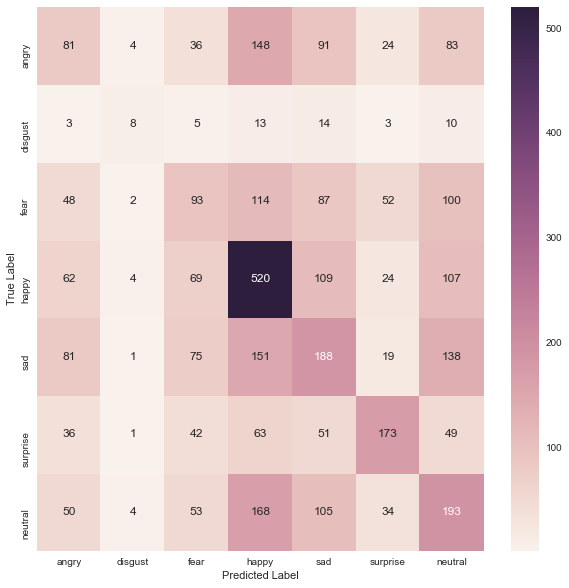

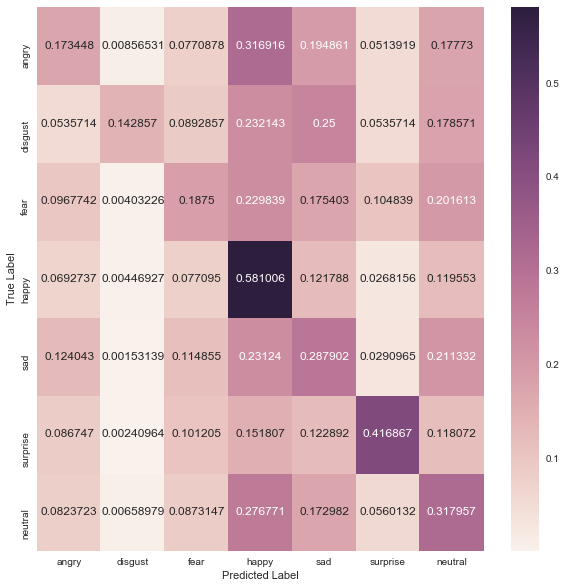

In [111]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_labels, test_preds)
classes = [get_emotion(np.array([i])) for i in range(7)]

plot_confusion_matrix(cnf_matrix, classes)
plot_confusion_matrix(cnf_matrix, classes, normalize=True)


[2 Marks] e. Which categories of faces seem to be most similar or least similar?

We look at the confusion matrices and look at each category and see what percentage of the true label was misclassified by each non true label class. For example, for angry faces, 32% of them were misclassified as being happy. However, looking at happy faces, we see that only 7% of them were misclassified as being happy. Now let's look at the following dummy example to motivate the creation of our similarity metric. If 50% of angry faces were misclassified as being happy and 50% of happy happy faces were misclassified as being angry, I say that these faces are the most similar since if we had a bunch of happy faces and angry faces, we'd be wrong 50% of the time, so we do no better than guessing.

To capture this idea, I have come up with the following formula for similarity.

$1 - \lvert m_{i,j}-0.5 \rvert \lvert m_{j,i}-0.5 \rvert$

$m_{i,j}$ is the i,jth element of the normalized confusion matrix


This tells us that **angry and happy** are the **most similar faces**. Looking at our confusion matrix, this seems to make sense. The second highest pair also seems to make sense (**happy, neutral**).

For **least similar**, we can get this information by just looking at the confusion matrix. In our case it would be, **disgust and surprise** or **disgust and angry**.

In [22]:
#Getting normalized version of confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_preds)
cnf_matrix_norm = cnf_matrix/np.sum(cnf_matrix, axis=1)[:, np.newaxis]

num_per_category = np.sum(cnf_matrix, axis=1)

print(num_per_category)

scores = []

#anonymous function that computes similarity score shown above
func = lambda a,b: 1 - abs(a - 0.5)*abs(b - 0.5)

#For every combination of i,j compute score
for tup in itertools.combinations(range(len(classes)),2):
    m_ij = cnf_matrix_norm[tup[0],tup[1]]
    m_ji = cnf_matrix_norm[tup[1],tup[0]]

    scores.append(((classes[tup[0]],classes[tup[1]]), func(m_ij,m_ji)))

#Sorted order
print(sorted(scores, key=lambda i: i[1], reverse=True))
            


[467  56 496 895 653 415 607]
[(('angry', 'happy'), 0.9211411242568157), (('happy', 'neutral'), 0.9150732147294598), (('sad', 'neutral'), 0.905600434946048), (('happy', 'sad'), 0.8983518269781926), (('fear', 'happy'), 0.8857474319697243), (('angry', 'sad'), 0.8852807500221347), (('fear', 'neutral'), 0.8768600201945049), (('disgust', 'sad'), 0.8753828483920367), (('fear', 'sad'), 0.874983018821321), (('disgust', 'happy'), 0.8672685554668795), (('angry', 'neutral'), 0.865411208985815), (('fear', 'surprise'), 0.8433637776914108), (('disgust', 'neutral'), 0.8414038597317016), (('happy', 'surprise'), 0.8352406273137242), (('surprise', 'neutral'), 0.8304291300291776), (('angry', 'fear'), 0.829470884851834), (('sad', 'surprise'), 0.8212836030185059), (('angry', 'surprise'), 0.8146113361368386), (('disgust', 'fear'), 0.7962989631336406), (('angry', 'disgust'), 0.7806095136127256), (('disgust', 'surprise'), 0.7778614457831325)]


[4 Marks] f. Let's assume that some of the faces were labeled wrong in producing the dataset. Propose and implement a solution that identifies images that are potentially mislabeled. Show 10 samples based on the method you choose.

We have to perform some form of outlier detection or anomaly detection. Here is my solution based on anomaly detection using OneClassSVMs.

Method 1:

1. Train N anomaly detection classifiers. Where N is the number of classes, which in our case would be the 7 different emotions. Each classifier only specializes in modelling 1 category, C, e.g. angry. I also add some extraneous examples from the training set which contain additional emotions that aren't necessarily from category C.
2. Now if we want to test if sample X with label Y is incorrectly labelled, we use the decision function given by model Y (e.g. the angry model). If the decision function predicts it to be not from class Y, the example might be an outlier.
3. Repeat this for all examples in the training set.

This approach seems to identify outliers with probability > 60%, but has a high false positive rate ~40% to ~50%.

I feel like this approach could work better if provided a powerful model with more input features. Here I am using LDA, which might not provide the best class separation. Perhaps if I used the entire input image and trained a more powerful model which can express more complex decision boundaries, the false positive rate could be lower.





Prev Labels:  [0 2 6 6 4 6 0 4 6 3]
Fake_labels:  [6 5 0 1 6 5 1 0 2 2]


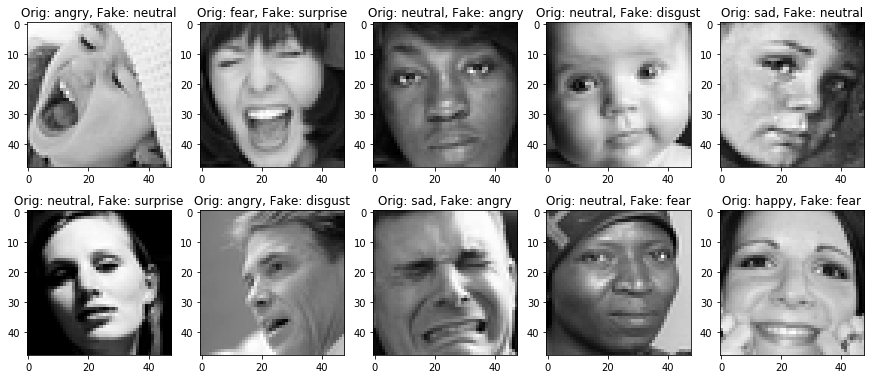

In [137]:
incorrect_indices = np.random.choice(len(x_training),10)
prev_labels = np.argmax(y_training[incorrect_indices],axis=1)

#anonymous function to help select label that isn't true label
sub = lambda i,v: np.array(list(set(list(range(i))) - set([v])))

#fake labels for the 10 randomly chosen faces
fake_labels = np.array([np.random.choice(sub(7,label)) for label in prev_labels])

print("Prev Labels: ", prev_labels)
print("Fake_labels: ", fake_labels)

columns = 5
rows = 2

fig=plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=-0.7)

#Plotting faces with original label and fake label
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.title("Orig: {}, Fake: {}".format(classes[prev_labels[i-1]],
                                              classes[fake_labels[i-1]]))
    plt.imshow(x_training[incorrect_indices[i-1]], cmap="gray")
    plt.grid(False)

plt.show()

#Creating one hot vector
one_hot = np.zeros((10,7))
one_hot[np.arange(10),fake_labels] = 1

#Changing the samples in the dataset to have the incorrect label
altered_labels = np.copy(y_training)
altered_labels[incorrect_indices] = one_hot



Correct Label:  angry
Incorrect Label:  neutral
Is neutral? No
Correct Label:  fear
Incorrect Label:  surprise
Is surprise? No
Correct Label:  neutral
Incorrect Label:  angry
Is angry? No
Correct Label:  neutral
Incorrect Label:  disgust
Is disgust? No
Correct Label:  sad
Incorrect Label:  neutral
Is neutral? No
Correct Label:  neutral
Incorrect Label:  surprise
Is surprise? No
Correct Label:  angry
Incorrect Label:  disgust
Is disgust? Yes
Correct Label:  sad
Incorrect Label:  angry
Is angry? No
Correct Label:  neutral
Incorrect Label:  fear
Is fear? No
Correct Label:  happy
Incorrect Label:  fear
Is fear? No
Identified 9 of 10 outliers

Incorrectly identified 16818 of 28699 images as outliers


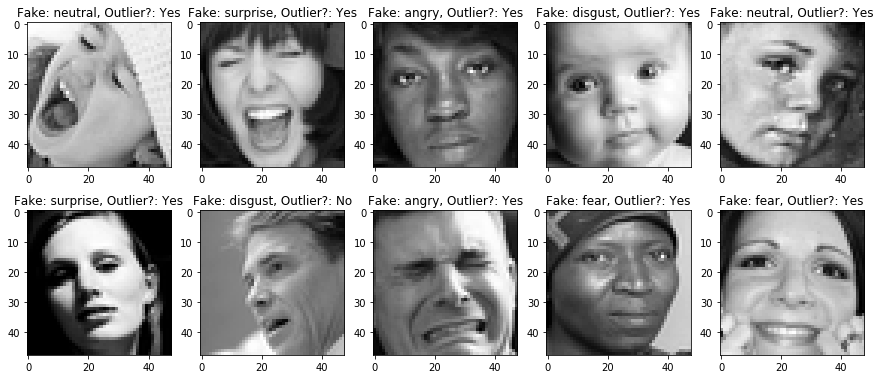

In [195]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import OneClassSVM

#rbf kernel and we assume 25% of the training examples aren't emotion C
#In the future, we might want to try scaling nu proportional to amount of training 
#samples of class C.
#Maybe something like this:
#((1 - proportion_of_C_in_train_set)*additional_examples)/(num_examples_of_type_C + additional_examples)

#Creating classifiers for each category i.e. angry, sad, happy etc..
classifiers = [OneClassSVM(kernel="linear", nu=0.25) for i in range(7)]
additional_percentage = 0.25

#For each classifier
for i in range(7):
    
    #Extract only images of class i
    emotion_indices = np.nonzero(altered_labels[:,i])
    emotion_data = res_lda[emotion_indices]
    
    #Add some additional data from the other classes
    additional_indices = np.random.choice(np.arange(res_lda.shape[0]), 
                                          round(additional_percentage*res_lda.shape[0]), replace=False)
    additional_data = res_lda[additional_indices]
    
    combined_data = np.concatenate((emotion_data, additional_data))
    
    #Fit to the combined data
    classifiers[i].fit(combined_data)

incorrect_samples = res_lda[incorrect_indices]

num_identified = 0
outlier = []

#For each image in our list of incorrect ones
for i,img in enumerate(incorrect_samples):
    
    #Have the classifier for the fake class predict if it doesn't belong
    pred = classifiers[fake_labels[i]].predict(np.expand_dims(img, axis=0))
    print("Correct Label: ", classes[prev_labels[i]])
    print("Incorrect Label: ", classes[fake_labels[i]])
    
    #If predicted as outlier append to list of outliers found and increase number 
    #of them identified
    print("Is {}? {}".format(classes[fake_labels[i]], "Yes" if pred == 1 else "No"))
    num_identified += 1 if pred != 1 else 0
    outlier.append(1 if pred != 1 else 0)
    
print("Identified {} of 10 outliers".format(num_identified))

#annonymous function to help select only correct examples
sub = lambda i,v: np.array(list(set(list(range(i))) - set(v)))

correct_indices = sub(res_lda.shape[0], incorrect_indices.tolist())
correct_samples = res_lda[correct_indices]
correct_targets = np.argmax(y_training[correct_indices], axis=1)

num_incorrect = 0

#For each correct example, see how many of them are identified as outliers
#Our false positive rate
for i,img in enumerate(correct_samples):
    correct_label = correct_targets[i]
    pred = classifiers[correct_label].predict(np.expand_dims(img, axis=0))
    num_incorrect += 1 if pred == -1 else 0
    
print("\nIncorrectly identified {} of {} images as outliers".format(num_incorrect, correct_targets.shape[0]))

columns = 5
rows = 2

fig=plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=-0.7)

#Plotting image and whether it was identified as outlier
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.title("Fake: {}, Outlier?: {}".format(classes[fake_labels[i-1]],
                                              "Yes" if outlier[i-1] else "No"))
    plt.imshow(x_training[incorrect_indices[i-1]], cmap="gray")
    plt.grid(False)

plt.show()

    


### 8318 only

From all the classification approaches considered above, choose one to score faces based on a continuous valued prediction of for each of the categories.

[6 Marks] a. Produce a prediction for each face in the test set (this has 7 dimensions). Visualize these based on a 2D embedding of the scores. The "data points" plotted in the embedding should show the actual picture of the face, at the corresponding 2D point location. (You could consider using t-SNE for your embedding)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

#Retraining logistic regression model for faces
clf = LogisticRegression()

train_labels = np.argmax(y_training,axis=1)

clf.fit(res_lda, train_labels)

transformed_test = lda.transform(x_testing.reshape(-1,48*48))

#Get output probabilities for test set
test_preds = clf.predict_proba(transformed_test)
test_labels = np.argmax(y_testing,axis=1)

tsne = TSNE(n_components=2)
tsne_res = tsne.fit_transform(test_preds)

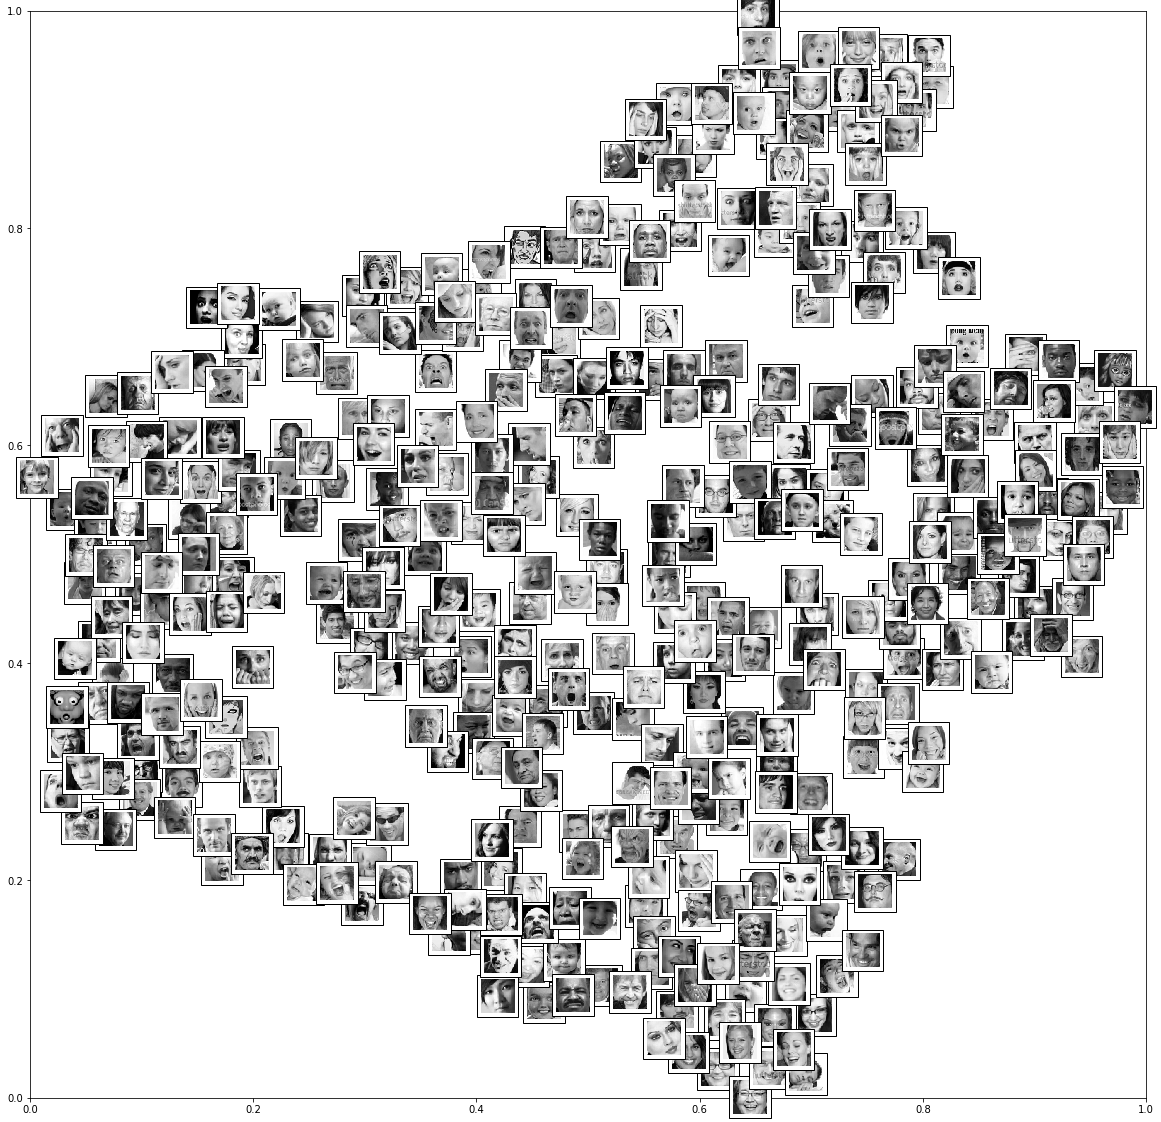

In [88]:
#Code inspired from 
#http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

from matplotlib import offsetbox
from numpy.linalg import norm

#Getting min x,y and max x,y coords
x_min, x_max = np.min(tsne_res, axis=0), np.max(tsne_res, axis=0)

#Normalizing so values lie between 0 and 1
X = (tsne_res - x_min) / (x_max - x_min)

plt.figure(figsize=(20,20))
ax = plt.subplot(111)

#Array containing list of images that have been plotted
shown_images = np.array([[10,10]])

for i in range(tsne_res.shape[0]):
    
    #Not showing images that overlap too much in terms of distance
    dist = norm(X[i] - shown_images, axis=1)
    if np.min(dist) < 0.025:
        continue
    
    #Add to list of images added
    shown_images = np.concatenate((shown_images, [X[i]]))
    
    #Adding ith image from test set at normalized tsne position i
    img = offsetbox.AnnotationBbox(offsetbox.OffsetImage(x_testing[i], cmap="gray", zoom=0.7),
        X[i])
    
    ax.add_artist(img)


plt.show()
